In [ ]:
from langchain_core.messages import AIMessage
from langchain_core.tools import tool

from langgraph.prebuilt import ToolNode
import os


# os.environ['HTTP_PROXY'] = 'http://127.0.0.1:10809'
# os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:10809'
os.environ['LANGSMITH_TRACING'] = 'true'
os.environ['LANGSMITH_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGSMITH_API_KEY'] = 'xxxxxxxxxxxxxxxxxxxx'
os.environ['LANGSMITH_PROJECT'] = 'xxxxxxxxxxxxxxxxxxxx'

## 定义工具

In [2]:
@tool
def get_weather(location: str):
    """Call to get the current weather."""
    if location.lower() in ["sf", "san francisco"]:
        return "It's 60 degrees and foggy."
    else:
        return "It's 90 degrees and sunny."


@tool
def get_coolest_cities():
    """Get a list of coolest cities"""
    return "nyc, sf"

In [3]:
tools = [get_weather, get_coolest_cities]
tool_node = ToolNode(tools)

## 手动调用 tool

ToolNode使用消息列表对图形状态进行操作。它要求列表中的最后一条消息是AIMessagewithtool_calls参数

In [4]:
message_with_single_tool_call = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "get_weather",
            "args": {"location": "sf"},
            "id": "tool_call_id",
            "type": "tool_call",
        }
    ],
)

tool_node.invoke({"messages": [message_with_single_tool_call]})

{'messages': [ToolMessage(content="It's 60 degrees and foggy.", name='get_weather', tool_call_id='tool_call_id')]}

可将多个工具调用传递给 AIMessage 的 tool_calls 参数，您还可以使用 ToolNode 进行并行工具调用：

In [5]:
message_with_multiple_tool_calls = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "get_coolest_cities",
            "args": {},
            "id": "tool_call_id_1",
            "type": "tool_call",
        },
        {
            "name": "get_weather",
            "args": {"location": "sf"},
            "id": "tool_call_id_2",
            "type": "tool_call",
        },
    ],
)

tool_node.invoke({"messages": [message_with_multiple_tool_calls]})

{'messages': [ToolMessage(content='nyc, sf', name='get_coolest_cities', tool_call_id='tool_call_id_1'),
  ToolMessage(content="It's 60 degrees and foggy.", name='get_weather', tool_call_id='tool_call_id_2')]}

## 与聊天模型一起使用

要将聊天模型与工具调用一起使用，我们首先需要确保模型知道可用的工具。调用 `.bind_tools` 方法来执行此操作

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o-mini",
    api_key="xxxxxxxxxxxxxxxxxxx",
    base_url="xxxxxxxxxxxxxxxxxxxxx"
)

model_with_tools = llm.bind_tools(tools)

In [7]:
model_with_tools.invoke("what's the weather in sf?").tool_calls

[{'name': 'get_weather',
  'args': {'location': 'San Francisco, CA'},
  'id': 'call_ip8vhHT4fEOz2FMJ8I9f0gGC',
  'type': 'tool_call'}]

聊天模型生成的 AI 消息已经 tool_calls 填充，因此我们可以将其直接传递给 ToolNode

In [8]:
tool_node.invoke({"messages": [model_with_tools.invoke("what's the weather in sf?")]})

{'messages': [ToolMessage(content="It's 60 degrees and foggy.", name='get_weather', tool_call_id='call_q2BVJPD02YF9z3x8RpjQUSxz')]}

## ReAct 代理

让我们看看如何在 LangGraph 图中使用 ToolNode。让我们设置 ReAct 代理的图形实现。此代理将一些查询作为输入，然后重复调用 tools，直到它有足够的信息来解析查询。

In [9]:
from typing import Literal

from langgraph.graph import StateGraph, MessagesState, START, END


def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, ["tools", END])
workflow.add_edge("tools", "agent")

app = workflow.compile()

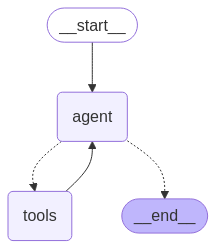

In [10]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [11]:
# example with a single tool call
for chunk in app.stream(
    {"messages": [("human", "what's the weather in sf?")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what's the weather in sf?
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_6JRBcRUDpbdaxGKxkLwVpyPS)
 Call ID: call_6JRBcRUDpbdaxGKxkLwVpyPS
  Args:
    location: San Francisco
================================= Tool Message =================================
Name: get_weather

It's 60 degrees and foggy.
================================== Ai Message ==================================

The weather in San Francisco is currently 60 degrees and foggy.


In [12]:
# example with a multiple tool calls in succession

for chunk in app.stream(
    {"messages": [("human", "what's the weather in the coolest cities?")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what's the weather in the coolest cities?
================================== Ai Message ==================================
Tool Calls:
  get_coolest_cities (call_LiPFcLy4Qw8cKdrbjn6Gr69p)
 Call ID: call_LiPFcLy4Qw8cKdrbjn6Gr69p
  Args:
================================= Tool Message =================================
Name: get_coolest_cities

nyc, sf
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_efhSbOSKcR95LVgq2aT3obFi)
 Call ID: call_efhSbOSKcR95LVgq2aT3obFi
  Args:
    location: nyc
  get_weather (call_5qQ129AP2ciavfezWIVBbGrD)
 Call ID: call_5qQ129AP2ciavfezWIVBbGrD
  Args:
    location: sf
================================= Tool Message =================================
Name: get_weather

It's 60 degrees and foggy.
================================== Ai Message ==================================

The weather in the coolest cities is as fo